Install Libs

In [ ]:
!git clone XXXXX
!mv ./beam_prediction/* .

In [1]:
!pip install wandb --upgrade
!pip install pytorch-lightning
!pip install albumentations
!pip install python-dotenv
!pip install torchmetrics

  Using cached wandb-0.10.26-py2.py3-none-any.whl (2.1 MB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached configparser-5.0.2-py3-none-any.whl (19 kB)
  Using cached psutil-5.8.0-cp38-cp38-manylinux2010_x86_64.whl (296 kB)
  Using cached subprocess32-3.5.4-py3-none-any.whl
  Using cached sentry_sdk-1.0.0-py2.py3-none-any.whl (131 kB)
  Using cached GitPython-3.1.14-py3-none-any.whl (159 kB)
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached pathtools-0.1.2-py3-none-any.whl
  Using cached PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached shortuuid-1.0.1-py3-none-any.whl (7.5 kB)
  Using cached protobuf-3.15.8-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
  Using cached gitdb-4.0.7-py3-none-any.whl (63 kB)
  Using cached smmap-4.0.0-py2.py3-none-any.whl (24 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Usi

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Pillow-8.2.0-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
  Using cached Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
  Using cached opencv_python-4.5.1.48-cp38-cp38-manylinux2014_x86_64.whl (50.4 MB)
  Using cached matplotlib-3.4.1-cp38-cp38-manylinux1_x86_64.whl (10.3 MB)
  Using cached PyWavelets-1.1.1-cp38-cp38-manylinux1_x86_64.whl (4.4 MB)
  Using cached tifffile-2021.4.8-py3-none-any.whl (165 kB)
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.3.1-cp38-cp38-manylinux1_x86_64.whl (1.2 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.7
    Uninstalling decorator-5.0.7:
      Successfully uninstalled de

Download Dataset

In [3]:
# https://drive.google.com/file/d//view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mQCNp8dq499qnJI0YCc0hTVfmm4ppxO5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mQCNp8dq499qnJI0YCc0hTVfmm4ppxO5" -O "download.tar.gz" && rm -rf /tmp/cookies.txt
!tar -xvf download.tar.gz

--2021-04-17 16:06:32--  https://docs.google.com/uc?export=download&confirm=9bgY&id=1mQCNp8dq499qnJI0YCc0hTVfmm4ppxO5
Resolving docs.google.com (docs.google.com)... 142.250.67.142, 2404:6800:4009:81e::200e
Connecting to docs.google.com (docs.google.com)|142.250.67.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-28-docs.googleusercontent.com/docs/securesc/5hrogu11ph7sqs80p2rrmvgn4diehp33/kimht97qdnksb0pp2j8ioks64oovcsip/1618675575000/18183255587859120126/11817150087953443504Z/1mQCNp8dq499qnJI0YCc0hTVfmm4ppxO5?e=download [following]
--2021-04-17 16:06:32--  https://doc-0o-28-docs.googleusercontent.com/docs/securesc/5hrogu11ph7sqs80p2rrmvgn4diehp33/kimht97qdnksb0pp2j8ioks64oovcsip/1618675575000/18183255587859120126/11817150087953443504Z/1mQCNp8dq499qnJI0YCc0hTVfmm4ppxO5?e=download
Resolving doc-0o-28-docs.googleusercontent.com (doc-0o-28-docs.googleusercontent.com)... 142.250.183.1, 2404:6800:4009:80d::2001
Connecting to doc-0o

# Utils


In [1]:
import glob
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from typing import Optional, Tuple

import pdb

# def calc_acc(pred: torch.tensor, y: torch.tensor, num_classes: int, return_class_wise_acc: bool = False):    pred = pred.argmax(1)
#     class_wise_acc = []
#     for i in range(num_classes):
#         tp = ((pred == i) & (y == i)).sum().float()
#         tn = ((pred != i) & (y != i)).sum().float()
#         fp = ((pred == i) & (y != i)).sum().float()
#         fn = ((pred != i) & (y == i)).sum().float()
#         acc = (tp + tn) / (tp + tn + fp + fn)
#         class_wise_acc.append(acc)
    
# #     pdb.set_trace()
#     class_wise_acc = torch.Tensor(class_wise_acc)
#     if return_class_wise_acc:
#         return class_wise_acc
#     return class_wise_acc.mean()

# Dataset

In [1]:
import glob
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from typing import Optional, Tuple

In [2]:
class BeamPredictionDataset(Dataset):
    """Beam Prediction dataset."""

    def __init__(self, file_path: str,
                 label_file_path: str,
                 reshape: bool=False,
                 transforms: Optional[transforms.Compose] = None,
                 preprocessing_fn: Optional[transforms.Compose] = None) -> None:
        """
        Init the Dataset
        """
        self.file_path = file_path
        self.label_file_path = label_file_path
        
        self.data = np.load(file_path)
        self.data = self.data.transpose((1, 0))
        
        self.label = np.load(label_file_path)
#         pdb.set_trace()
        
        assert len(self.label) == len(self.data)
        # reshape is true
        # num_users x num_channels x num_antennas x real/imaginary
        if reshape:
            self.data = self.data.reshape((2, 4, 32, -1))
            self.data = self.data.transpose((3, 2, 1, 0))
            
#             self.data = self.data.reshape((4, 2, 32, -1))
#             self.data = self.data.transpose((3, 2, 0, 1))
            
#             self.data = self.data.reshape((32, 4, 2, -1))
#             self.data = self.data.transpose((3, 0, 1, 2))
            
#             self.data = self.data.reshape((32, 2, 4, -1))
#             self.data = self.data.transpose((3, 0, 2, 1))
            
        self.preprocessing_fn = preprocessing_fn
        self.transforms = transforms

    def __len__(self) -> int:
        """
        Returns the total length of dataset.
        """
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Gets an item from dataset
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        user_data = self.data[idx]
        
        if self.preprocessing_fn is not None:
            user_data = self.preprocessing_fn(user_data)
        
        if self.transforms is not None:
            user_data = self.transforms(user_data)
        
        label = self.label[idx]
        label = torch.Tensor(label).type(torch.int64) - 1
        return user_data, label
    
def transform(x: np.array) -> torch.Tensor:
    # mean normalize
    x -= x.mean()
    x /= x.std()
    x = torch.Tensor(x)
    return x

In [3]:
# example ds

ds = BeamPredictionDataset(
    file_path='./Dataset_-17.3375dB/-17.3375dB_inpTrain.npy',
    label_file_path='./Dataset_-17.3375dB/-17.3375dB_labelTrain.npy',
    reshape=True,
    transforms=transform
)
it = iter(ds)
out = next(it)
print(out)

(tensor([[[ 1.6181,  0.1818],
         [-0.4459, -0.3744],
         [ 1.5318,  1.3560],
         [ 1.4244,  1.0078]],

        [[-0.8836,  0.9129],
         [ 0.9903, -0.7938],
         [-1.1088,  0.1316],
         [ 0.9276, -1.4299]],

        [[-0.2923, -0.6195],
         [ 0.3086,  0.1916],
         [ 1.5332,  0.8968],
         [ 1.8444, -1.2352]],

        [[-0.3870,  1.3273],
         [-0.5871, -0.0795],
         [ 0.8074,  0.4232],
         [-0.5954, -1.0179]],

        [[ 1.6142,  0.8671],
         [-1.0867,  0.3455],
         [-0.1197,  0.5889],
         [ 1.2489,  0.9079]],

        [[ 1.1627,  0.9474],
         [-1.2938, -0.3450],
         [ 0.4036, -0.1070],
         [ 0.3058, -0.0580]],

        [[-2.1582, -1.4733],
         [ 2.2513, -1.0224],
         [-0.9013, -0.7257],
         [-0.4550,  0.9563]],

        [[ 1.0969, -0.7654],
         [-0.4696,  0.0300],
         [ 0.4124, -0.3771],
         [-3.9784,  0.4875]],

        [[ 0.2948, -0.2555],
         [ 1.9661,  0.3008

In [6]:
out[0].shape

torch.Size([32, 4, 2])

# Model

In [60]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
import wandb
from argparse import ArgumentParser
from typing import Tuple
from torchmetrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pdb

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class BeamClassifier(pl.LightningModule):

    def __init__(self, hparams) -> None:
        """
        Downloading Backbone and defining structure of model.
        """
        super().__init__()
        # args from argparser
        self.hparams = hparams
        in_ch = self.hparams.in_ch
        out_ch = self.hparams.out_ch
        mid_ch = self.hparams.mid_ch
        
        self.first_conv = nn.Sequential(
            # first 
            nn.Conv2d(self.hparams.in_ch, mid_ch, kernel_size=(4,2), padding=(2, 1)),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(),
            nn.Dropout2d(self.hparams.dropout_prob),
        )
        layers = nn.ModuleList()
        for i in range(self.hparams.num_layers):
            layers.append(
                nn.Sequential(
                    nn.Conv2d(mid_ch, mid_ch, kernel_size=(1,2), padding=(0, 1)),
                    nn.BatchNorm2d(mid_ch),
                    nn.ReLU(),
                    nn.Dropout2d(self.hparams.dropout_prob),
                )
            )
           # layers
        self.layers = nn.Sequential(*layers)
            
        self.adap_avg = nn.AdaptiveAvgPool2d(1)
        
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(mid_ch, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.hparams.dropout_prob),
            
            nn.Linear(64, self.hparams.out_ch)
        )
        
        self._acc_metric = Accuracy()
        self._top2_acc_metric = Accuracy(top_k=2)
        self._precision = Precision(average='macro', 
                                   num_classes=self.hparams.out_ch)
        self._recall = Recall(average='macro', 
                             num_classes=self.hparams.out_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward step of model.
        """
        b, c, h, w = x.shape
        
#         pdb.set_trace()
        
        first Conv
        x = self.first_conv(x)
        
        x = self.layers(x)
        x = self.adap_avg(x)
        
        # FC Layer
        x = x.view(b, -1) 
        x = self.classifier(x)
        return x

    def loss_fn(self, pred: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Loss function used for model"""
        y_sq = y.squeeze(-1)
        loss = F.cross_entropy(pred, y_sq)
        return loss
    
    def configure_optimizers(self) -> torch.optim:
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        opt = torch.optim.Adam(self.parameters(),
                               lr=self.hparams.learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, self.hparams.max_nb_epochs, self.hparams.learning_rate)
        self.lr_scheduler = lr_scheduler
#         lr_scheduler = None
        return [opt], [lr_scheduler]

    def train_dataloader(self) -> DataLoader:
        """Define the data loader for training data"""
        # REQUIRED
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_-17.3375dB/-17.3375dB_inpTrain.npy',
                                label_file_path='./Dataset_-17.3375dB/-17.3375dB_labelTrain.npy',
                                reshape=True,
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers,
                          shuffle=True)

    def training_step(self, batch: list, batch_idx: int) -> dict:
        """Backward step of model"""
        # REQUIRED
        x, y = batch
        pred = self.forward(x)

        loss = self.loss_fn(pred, y)
        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        
        # metrics
        acc = self._acc_metric(pred, y_sq)
        prec = self._precision(pred, y_sq)
        rec = self._recall(pred, y_sq)
        
        if self.lr_scheduler is not None:
            lr = self.lr_scheduler.get_last_lr()[0]

        if(batch_idx % self.hparams.wandb_log_num_iter == 0):
            wandb.log({
                'train_loss': loss,
            })
            
        return {
            'loss': loss,
            'train_acc': acc,
            'train_prec': prec,
            'train_rec': rec
        }
    
    def training_epoch_end(self, outputs: list) -> None:
        acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        prec = torch.stack([x['train_prec'] for x in outputs]).mean()
        rec = torch.stack([x['train_rec'] for x in outputs]).mean()
        
        if self.lr_scheduler is not None:
            lr = self.lr_scheduler.get_last_lr()[0]
        else:
            lr = self.hparams.learning_rate
        logs = {
            'lr': lr,
            'train_acc': acc,
            'train_prec': prec,
            'train_rec': rec
        }
        wandb.log(logs)
        self.log_dict(logs)
    
    def val_dataloader(self) -> DataLoader:
        """Define the data loader for validation data"""
        # OPTIONAL
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_-17.3375dB/-17.3375dB_inpVal.npy',
                                label_file_path='./Dataset_-17.3375dB/-17.3375dB_labelVal.npy',
                                reshape=True,
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers
                         )

    def validation_step(self, batch: list, batch_idx: torch.Tensor) -> dict:
        """Validation step to be carried out on validation data."""
        # REQUIRED
        # pdb.set_trace()
        x, y = batch
        
        pred = self.forward(x)

        loss = self.loss_fn(pred, y)
        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        
        acc = self._acc_metric(pred, y_sq)
        prec = self._precision(pred, y_sq)
        rec = self._recall(pred, y_sq)

        return {
            'val_loss': loss,
            'val_acc': acc,
            'val_prec': prec,
            'val_rec': rec
        }

    def validation_epoch_end(self, outputs: list) -> None:
        """Use results from each validation step to generate validation stats at epoch end"""
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        val_prec = torch.stack([x['val_prec'] for x in outputs]).mean()
        val_rec = torch.stack([x['val_rec'] for x in outputs]).mean()
        
        logs = {
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_prec': val_prec,
            'val_rec': val_rec
        }
        wandb.log(logs)
        self.log_dict(logs)
    
    def test_dataloader(self) -> DataLoader:
        """Define the data loader for test data"""
        print("Test Dataloader")
        # OPTIONAL
        return DataLoader(BeamPredictionDataset(
                                file_path='./Dataset_-17.3375dB/-17.3375dB_inpVal.npy',
                                label_file_path='./Dataset_-17.3375dB/-17.3375dB_labelVal.npy',
                                reshape=True,
                                transforms=transform
                            ),
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers
                         )
    
    def test_step(self, batch: list, batch_idx: torch.Tensor) -> dict:
        """Validation step to be carried out on validation data."""
        # REQUIRED
#         pdb.set_trace()
        x, y = batch
        
        pred = self.forward(x)        
        pred = F.softmax(pred, dim=-1)
        y_sq = y.squeeze(-1)
        logs = {
            'pred': pred,
            'ground_truth': y_sq
        }
#         self.log_dict(logs)
        return logs
    
    def test_epoch_end(self, outputs: list) -> None:
        """Use results from each validation step to generate validation stats at epoch end"""
        pred = torch.cat([x['pred'] for x in outputs], dim=0)
        ground_truth = torch.cat([x['ground_truth'] for x in outputs], dim=0)

        top1_acc = self._acc_metric(pred, ground_truth)
        top2_acc = self._top2_acc_metric(pred, ground_truth)
        
#         pdb.set_trace()
        conf_matrix = confusion_matrix(ground_truth.tolist(), 
                                       pred.argmax(-1).tolist(), 
                                       labels=list(range(self.hparams.out_ch)))
        df_cm = pd.DataFrame(conf_matrix, index = [str(i) for i in range(self.hparams.out_ch)],
                  columns = [str(i) for i in range(self.hparams.out_ch)])
        
        plt.figure(figsize = (50,50))
        ax = sns.heatmap(df_cm, annot=True)
        logs = {
            'top1_acc': top1_acc,
            'top2_acc': top2_acc,
            'conf_matrix': wandb.Image(ax)
        }
        wandb.log(logs)
    

    def load_encoder_weights(self) -> None:
        """Loads encoder weights from ckpt"""
        ckpt = torch.load(self.hparams.encoder_ckpt_path)
        pretrained_dict = ckpt['state_dict']
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if (
            'encoder' in k) and (k in model_dict)}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

    def load_model_weights_from_ckpt(self) -> None:
        """Load model weights to model on cpu"""
        ckpt = torch.load(self.hparams.model_ckpt_path,
                          map_location=torch.device('cpu'))
        pretrained_dict = ckpt['state_dict']
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k,
                           v in pretrained_dict.items() if (k in model_dict)}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        
    def _get_learning_rate(self) -> float:
        i = 0
        for param_group in self._optimizer.param_groups:
            if i == 0:
                learning_rate = param_group["lr"]
            else:
                if learning_rate != param_group["lr"]:
                    raise ValueError(
                        "different param groups have different lr")
        return learning_rate

    @staticmethod
    def add_model_specific_args(parent_parser: ArgumentParser) -> ArgumentParser:
        """
        Specify the hyperparams for this LightningModule
        """
        # MODEL specific arguments
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', default=0.02, type=float)
        parser.add_argument('--batch_size', default=32, type=int)
        parser.add_argument('--in_ch', default=256, type=int)
        parser.add_argument('--out_ch', default=64, type=int)
        parser.add_argument('--num_workers', default=1, type=int)
        parser.add_argument('--max_nb_epochs', default=1, type=int)
        parser.add_argument('--dropout_prob', default=0.5, type=float)
        parser.add_argument('--num_layers', default=8, type=int)
        parser.add_argument('--mid_ch', default=128, type=int)
        return parser

In [61]:
from argparse import ArgumentParser, Namespace
args_str = [
        # model related args
        '--max_nb_epochs=1',
        '--learning_rate=1e-3',
        '--batch_size=16',
        '--in_ch=256',
        '--out_ch=64',
        '--num_workers=4'
]
parser = ArgumentParser(add_help=False)
parser = BeamClassifier.add_model_specific_args(parser)
args= parser.parse_args(args_str)

model = BeamClassifier(args)
train_dl = model.train_dataloader()
it = iter(train_dl)
x, y = next(it)


pred = model(x)
loss = model.loss_fn(pred, y)
print(loss)

tensor(4.2552, grad_fn=<NllLossBackward>)


# Trainer

In [77]:
args_str = ['--tpu_cores=0',
        '--progress_bar_refresh_rate=20',
        '--wandb_run_name=CNN Style 1024',
        '--wandb_project_name=Beam Prediction',
        '--wandb_log_num_iter=1',
        '--gpus=1',
        # model related args
        '--max_nb_epochs=100',
        '--learning_rate=1e-2',
        '--batch_size=256',
        '--in_ch=256',
        '--out_ch=64',
        '--num_workers=4',
        '--dropout_prob=0.1',
        '--num_layers=1',
        '--mid_ch=2048'
    ]

Global seed set to 123


val_loss,4.00854
val_acc,0.03235
val_prec,0.0037
val_rec,0.01544
_runtime,80
_timestamp,1618764674
_step,1935
train_loss,3.97859
lr,0.01
train_acc,0.03861
train_prec,0.00779


val_loss,█▁▁▁▁▁▂
val_acc,▁█▆▇█▇▇
val_prec,▁▇▅█▅▇▇
val_rec,▄█▁▄▅▃▃
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▆▆▅▅▅▆▄▅▇▃▅▄▆▅▄▆▂▃▄▆▆▄▆▂▂▁▅▄▅▆▆▅▄▃▃▃▁▄
lr,▁▁▁▁▁▁
train_acc,▁▄▅▆▇█
train_prec,▃▁▂▃▅█


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | first_conv       | Sequential        | 530 K 
1 | layers           | Sequential        | 8.4 M 
2 | adap_avg         | AdaptiveAvgPool2d | 0     
3 | classifier       | Sequential        | 135 K 
4 | _acc_metric      | Accuracy          | 0     
5 | _top2_acc_metric | Accuracy          | 0     
6 | _precision       | Precision         | 0     
7 | _recall          | Recall            | 0     
-------------------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.242    Total estimated model params size (MB)


Epoch 0:   0%|          | 1/426 [00:00<03:04,  2.30it/s, loss=4.21, v_num=]

/home/ubuntu/miniconda3/envs/619/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 0:  70%|██████▉   | 298/426 [00:22<00:09, 13.28it/s, loss=4, v_num=]   
Validating: 0it [00:00, ?it/s]
Epoch 1:  42%|████▏     | 181/426 [00:13<00:18, 12.97it/s, loss=3.99, v_num=]


/home/ubuntu/miniconda3/envs/619/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test Dataloader
Testing: 100%|██████████| 128/128 [00:08<00:00, 15.31it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


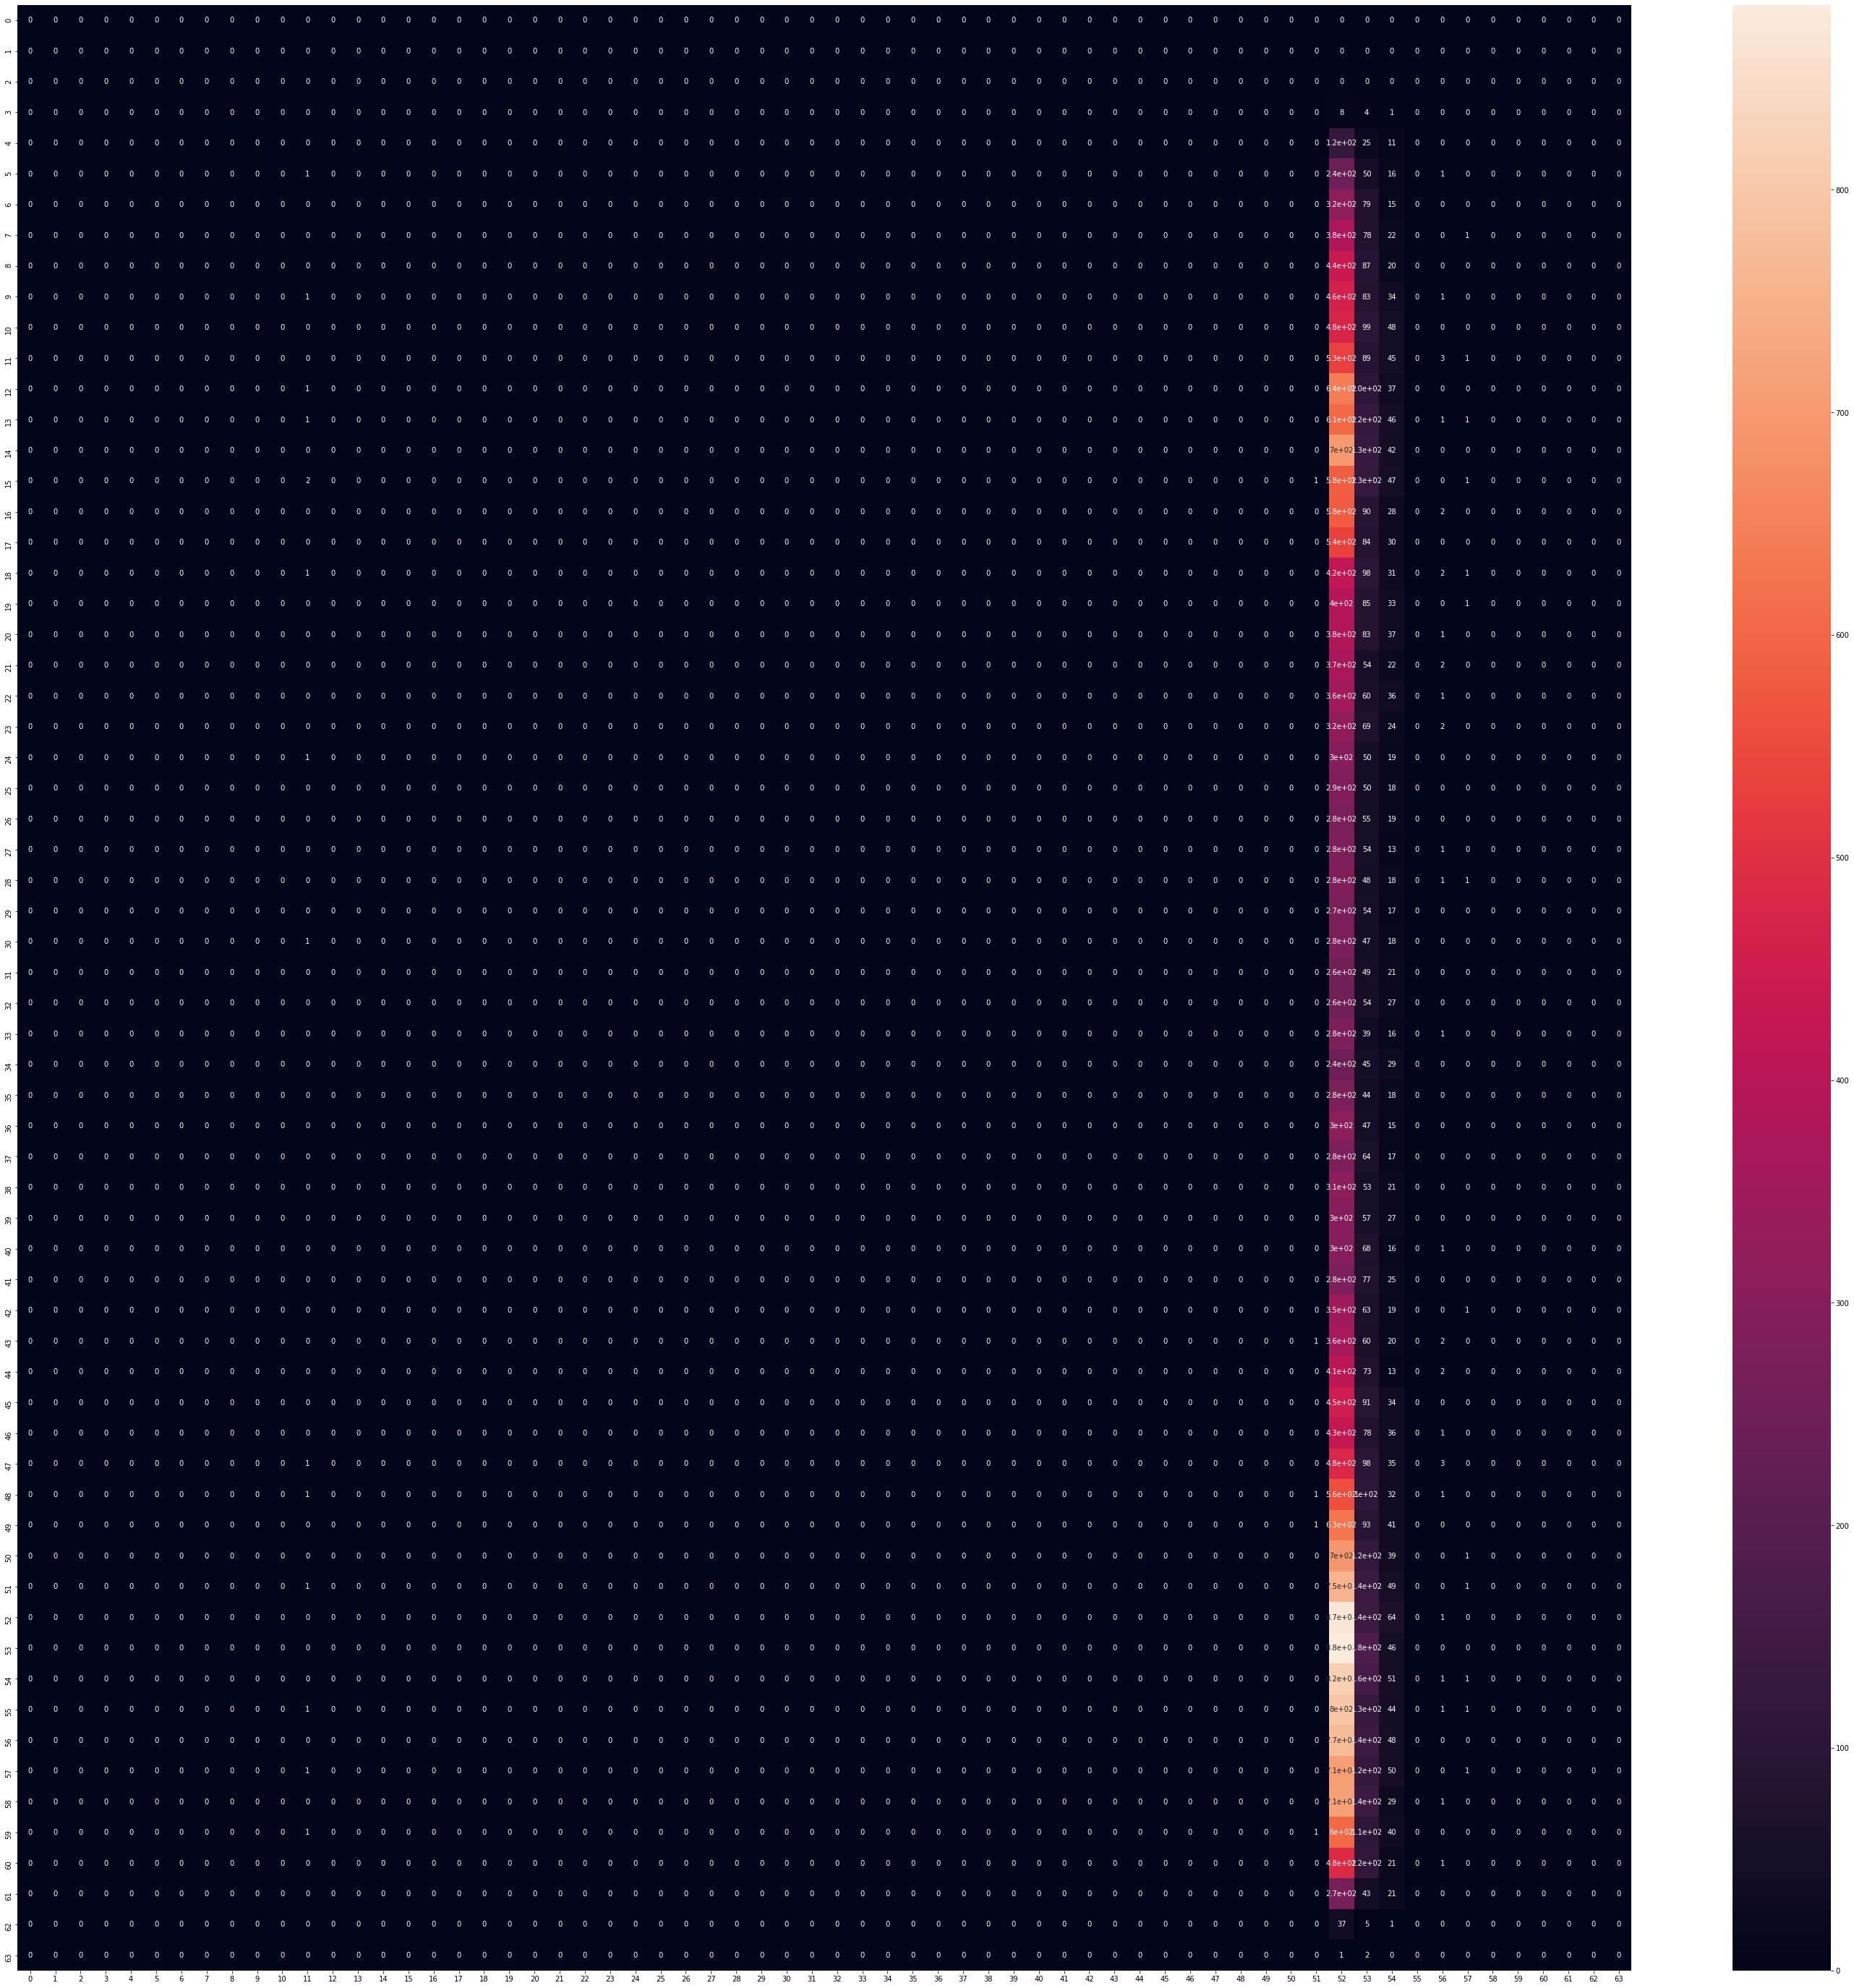

In [78]:
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser, Namespace
import wandb
from pytorch_lightning.callbacks import ModelCheckpoint
from dotenv import load_dotenv

PROJECT_ROOT = os.path.dirname(os.path.abspath('.'))
load_dotenv(dotenv_path=os.path.join(PROJECT_ROOT, '.env'))

# import pdb

parser = ArgumentParser(add_help=False)
parser.add_argument('-wandb_run_name',
                '--wandb_run_name',
                help='Name of Wandb Run',
                default='run',
                type=str)
parser.add_argument('-wandb_project_name',
                    '--wandb_project_name',
                    help='Wandb Project Name',
                    default='deep_dream',
                    type=str)
parser.add_argument('-model_ckpt_path',
                    '--model_ckpt_path',
                    help='Model Checkpoint Path',
                    default='./ckpts/model.ckpt',
                    type=str)
parser.add_argument('-wandb_log_num_iter',
                    '--wandb_log_num_iter',
                    help='After how many batches, we will log in training loop',
                    default=1,
                    type=int)
parser.add_argument('-init_ckpt',
                    '--init_ckpt',
                    help='Initial Ckpt',
                    default=None,
                    type=str)

def main(args):
    """Main function that will perform all the training"""
    # init module
    model = BeamClassifier(args)

    # Using Wandblogger so that we can log our results to wandb
    wandb.init(name=args.wandb_run_name,
               project=args.wandb_project_name,
               config=vars(args))
        
    wandb.watch(model)

    # most basic trainer, uses good defaults
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='./ckpts',
        filename='{epoch:02d}-{val_loss:.2f}'
    )
    trainer = Trainer(logger=[], 
                      gpus=args.gpus, 
                      max_epochs=args.max_nb_epochs, 
                      resume_from_checkpoint=args.init_ckpt)
#     pdb.set_trace()
    trainer.fit(model)
    trainer.test(model)
    
    ckpt_path = os.path.join('./ckpt', f"{args.wandb_project_name}", f"{args.wandb_run_name}.ckpt")
    ckpt_base_path = os.path.dirname(ckpt_path)
    trainer.save_checkpoint(ckpt_path)
    wandb.save(ckpt_path)

    return model

if __name__ == '__main__':

    # auto add args from trainer
    parser = Trainer.add_argparse_args(parser)

    # give the module a chance to add own params
    # good practice to define LightningModule speficic params in the module
    parser = BeamClassifier.add_model_specific_args(parser)

    # parse params
    args= parser.parse_args(args_str)

    seed_everything(123)

    model = main(args)